In [13]:
import fsspec
import h5py
import os
import scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

In [15]:
# local files 
# we downloaded all data within the bounding box of bounding_box = '-77,38.5,-76,39.5'
data_dir = '/home/jovyan/data/glas/example/'

In [38]:
# # files on gcp 
# fs = fsspec.get_filesystem_class('gs')(account_name='carbonplan')
# data_dir = ''
# all_files = fs.ls(path='carbonplan-scratch/glas-cache/')
# example_files = [f for f in all_files if not f.endswith('.xml')]
# print(len(example_files))

# Let's try to find the exact record that Sun et al 2008 used 

In [18]:
# try to find the record Sun et al 2008 uses by the record number 
rec = 246268022

def find_record_in_local_files(
    target_rec, 
    var_name, 
    data_dir,
    product_num=None,
):
    if not product_num:
        product_num = ''
    
    all_files = [f for f in os.listdir(data_dir) if not f.endswith('.xml') and f.startswith('GLAH'+product_num)]
    
    target_file = None

    for file in all_files:
        f = h5py.File(data_dir + file, 'r')
        records = f[var_name][:]
        if target_rec in records: 
            print('found record!')
            print(file)
            target_file = file            
    
    if not target_file:
        print(target_file or 'Did not find record')
        
    return target_file
    
find_record_in_local_files(rec, 'Data_1HZ/Time/i_rec_ndx', data_dir)

Did not find record


In [19]:
lat = 39.013840  # 39.021599 
lon = 283.156830

In [20]:
find_record_in_local_files(lat, 'Data_40HZ/Geolocation/d_lat', data_dir, '14')

Did not find record


In [21]:
find_record_in_local_files(lon, 'Data_40HZ/Geolocation/d_lon', data_dir, '14')

Did not find record


In [22]:
find_record_in_local_files(lat, 'Data_1HZ/Geolocation/d1_pred_lat', data_dir, '01')

Did not find record


In [23]:
# how about find records in the vicinity of the lat/lon of our interest 

def match_lat_lng_in_record_files(
    lat, 
    lon,
    data_dir,
    product_num=None,
    buffer=0,
):
    if not product_num:
        product_num = ''
    
    all_files = [f for f in os.listdir(data_dir) if not f.endswith('.xml') and f.startswith('GLAH'+product_num)]
    
    target_file = []

    for file in all_files:
        f = h5py.File(data_dir + file, 'r')
        lats = f['Data_40HZ/Geolocation/d_lat'][:]
        lons = f['Data_40HZ/Geolocation/d_lon'][:]
        rec_nums = f['Data_40HZ/Time/i_rec_ndx'][:]
        
        matching_records = rec_nums[np.where((lats > lat-buffer) & 
                                             (lats < lat+buffer) & 
                                             (lons > lon-buffer) & 
                                             (lons < lon+buffer))]
        if len(matching_records) > 0: 
            print('found record!')
            print(np.unique(matching_records))
            print(file)
            target_file.append(file)        
    
    if not target_file:
        print('Did not find record')
        
    return target_file

In [24]:
buff = 0.1

match_lat_lng_in_record_files(
    lat, 
    lon,
    data_dir,
    product_num='14',
    buffer=buff,
)

# we found many records! 

found record!
[226677184 226677189 226677194 226677199]
GLAH14_634_2107_003_0239_0_01_0001.H5


['GLAH14_634_2107_003_0239_0_01_0001.H5']

# Looks like we can't find the exact record, but we can find nearby ones
# Let's just pick a nearby one at random to work with

In [25]:
# let's just pick one at random to work with 

record = 226677189

In [26]:
# get the file names 
file01 = find_record_in_local_files(record, 'Data_1HZ/Time/i_rec_ndx', data_dir, '01')
file14 = find_record_in_local_files(record, 'Data_1HZ/Time/i_rec_ndx', data_dir, '14')


found record!
GLAH01_033_2107_003_0241_4_02_0001.H5
found record!
GLAH14_634_2107_003_0239_0_01_0001.H5


In [27]:
# at least we proved that we can find matching records from GLAH14 to GLAH01... 
# let's now take this example and try to duplicate Sun's analysis

In [29]:
f01 = h5py.File(data_dir + file01, 'r')
f14 = h5py.File(data_dir + file14, 'r')


# Get raw data from H5 file and put into xarray format

In [31]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr

def read_dimensions(file_handle):
    # put the dimension columns into a dataframe
    df = {}
    df['record_index'] = file_handle['Data_40HZ/Time/i_rec_ndx'][:]
    df['shot_number'] = file_handle['Data_40HZ/Time/i_shot_count'][:]
    df = pd.DataFrame(df)
    
    # concat two columns to get an unique index, but also set these two columns as multi level index 
    df['unique_index'] = df.record_index.astype(str).str.zfill(9) + '_' + df.shot_number.astype(str).str.zfill(2)
    df.set_index(['record_index', 'shot_number'], inplace=True)
    
    return df

def read_1d_variables(file_handle, mapping, unique_index, replace_fill_values_with_nulls):
    # put the 1D variables into a xarray dataset 
    ds = {}
    for k, v in mapping.items():
        temp = file_handle[v][:]
        if replace_fill_values_with_nulls:
            temp[(temp > 1e+100)] = np.nan
        ds[k] = xr.DataArray(temp, dims=['unique_index'], coords={'unique_index': unique_index})
    
    return xr.Dataset(ds)
    
    
def extract_GLAH01_data(filename, replace_fill_values_with_nulls=True):
    """
    Given file name of a HDF5 GLAH01 data, returns a xarray dataset with record index and shot number being the primary dimensions. 
    rec_bin and tx_bin are additional dimensions regarding the transmitted and received waveforms. 
    """
    
    # read file
    f = h5py.File(filename, 'r')
    
    # list out all 1D variables we want and read into a dataframe 
    name_map = {
        # Background Noise Mean Value for the 4 ns filter. From APID12/13, Offset 112.
        'noise_mean': 'Data_40HZ/Waveform/Characteristics/d_4nsBgMean',  # volts 
        # The standard deviation of the background noise for the 4 ns filter. From APID12/13, Offset 116.
        'noise_sd': 'Data_40HZ/Waveform/Characteristics/d_4nsBgSDEV',  # volts 
        'rec_wf_location_ind': 'Data_40HZ/Waveform/RecWaveform/i_rec_wf_location_index',  # This is an index into the array of 544 times within the rec_wf_sample_location_table (found in the ANCILLARY_DATA group)
        'rec_wf_response_end_time': 'Data_40HZ/Waveform/RecWaveform/i_RespEndTime',
        'tx_wf_peak_time': 'Data_40HZ/Waveform/TransmitWaveform/i_time_txWfPk',  # Address in digitizer counts of the Transmit Pulse Peak as measured from the start of Acquisition Memory, i.e. start of digitization. From APID12/13, Offset 68.
#     'wf_type': 'Data_40HZ/Waveform/Characteristics/i_waveformType', # Indicates number of valid samples in waveform; 0 = missing; 1 = Long waveform (544 samples); 2 =Short waveform (200 samples),
#     'tx_wf_start_time': 'Data_40HZ/Waveform/TransmitWaveform/i_TxWfStart'  # Starting Address in digitizer counts of the Transmit Pulse sample relative to the start of digitization. From APID12/13, Offset 76.	
    }
    
    # put the dimension columns into a dataframe
    df = read_dimensions(f)
    
    # put the 1D variables into a xarray dataset 
    ds = read_1d_variables(file_handle=f, mapping=name_map, unique_index=df.unique_index.values, replace_fill_values_with_nulls=False)

    # read the 2D variables we want 
    # Transmit Pulse 48 waveform samples in calibrated volts. The delta times for transmit waveform sample j is provided in the attribute array tx_wf_sample_location_table (j).
    tx_wf = f['Data_40HZ/Waveform/TransmitWaveform/r_tx_wf'][:]
    # The delta times for each echo of the 544 waveform samples is provided within the 544 times stored in rec_wf_sample_location_table 
    # (an attribute in the /ANCILLARY_DATA group) and indexed by i_rec_wf_location_index.
    rec_wf = f['Data_40HZ/Waveform/RecWaveform/r_rng_wf'][:]  # n (num shot * num records) x 544 
    tx_wf_sample_loc = f['ANCILLARY_DATA'].attrs['tx_wf_sample_location_table']
    rec_wf_sample_loc = f['ANCILLARY_DATA'].attrs['rec_wf_sample_location_table']  # 5 x 544
    
    if replace_fill_values_with_nulls:
        rec_wf_sample_loc[(rec_wf_sample_loc > 1e+10)] = np.nan
        
    # put the 2D variables into xarray 
    ds['rec_wf'] = xr.DataArray(rec_wf, dims=['unique_index', 'rec_bin'], coords=[df.unique_index.values, np.arange(rec_wf.shape[1])])
    ds['tx_wf'] = xr.DataArray(tx_wf, dims=['unique_index', 'tx_bin'], coords=[df.unique_index.values, np.arange(tx_wf.shape[1])])
    ds['tx_wf_sample_loc'] = xr.DataArray(tx_wf_sample_loc, dims=['tx_bin'], coords=[np.arange(tx_wf.shape[1])])

    # store a copy of the sample location for each unique shot 
    ds['rec_wf_sample_loc'] = xr.DataArray(rec_wf_sample_loc[ds.rec_wf_location_ind - 1], dims=['unique_index', 'rec_bin'], coords=[df.unique_index.values, np.arange(rec_wf.shape[1])])
    
    # expand the multi index 
    ds.coords['unique_index'] = df.index
    ds = ds.unstack('unique_index')
    
    return ds

def extract_GLAH14_data(filename, replace_fill_values_with_nulls=True):
    """
    Given file name of a HDF5 GLAH14 data, returns a xarray dataset with record index and shot number being the primary dimensions. 
    rec_bin and tx_bin are additional dimensions regarding the transmitted and received waveforms. 
    """
    
    # read file
    f = h5py.File(filename, 'r')
    
    # list out all 1D variables we want and read into a dataframe 
    name_map = {
        # The transmit time of each shot in the 1 second frame measured as UTC seconds elapsed since Jan 1 2000 12:00:00 UTC. This time has been derived from the GPS time accounting for leap seconds.
        'time': 'Data_40HZ/Time/d_UTCTime_40',  
        'lat': 'Data_40HZ/Geolocation/d_lat',
        'lon': 'Data_40HZ/Geolocation/d_lon',
        # the documentation mentioned two flags sat_corr_flg and i_satNdx to signal bad elevation, also and when correction is invalid the elevation is invalid 
        'elevation': 'Data_40HZ/Elevation_Surfaces/d_elev',  # meters 
        'elevation_correction': 'Data_40HZ/Elevation_Corrections/d_satElevCorr',  # should be added to elevation 
        # Range in distance calculated from the time between the centroid of the transmit pulse and the farthest gate from the spacecraft of the received pulse. See the rngcorrflg to determine 
        # any corrections that have been applied. unit is meters and values in the 600k range 
        'ref_range': 'Data_40HZ/Elevation_Surfaces/d_refRng',  # meters 
        # these should be added to centroid according to the documentation 
        'sig_begin_offset': 'Data_40HZ/Elevation_Offsets/d_SigBegOff',  # meters 
        'sig_end_offset': 'Data_40HZ/Elevation_Offsets/d_SigEndOff',  # meters 
        # Range offset to be added to d_refRng to calculate the range using the algorithm deemed appropriate for land.
        'centroid_offset': 'Data_40HZ/Elevation_Offsets/d_ldRngOff',  # meters 
        # data for the 6 fitted gaussian peaks 
#         'num_gaussian_peaks': 'Data_40HZ/Waveform/i_numPk', 
#         'gaussian_mu': 'Data_40HZ/Elevation_Offsets/d_gpCntRngOff',  # meters 
#         'gaussian_amp': 'Data_40HZ/Waveform/d_Gamp',  # volts 
#         'gaussian_sigma': 'Data_40HZ/Waveform/d_Gsigma',  # ns
    }
    
    # put the dimension columns into a dataframe
    df = read_dimensions(f)
    
    # put the 1D variables into a xarray dataset 
    ds = read_1d_variables(file_handle=f, mapping=name_map, unique_index=df.unique_index.values, replace_fill_values_with_nulls=replace_fill_values_with_nulls)
    
    # expand the multi index 
    ds.coords['unique_index'] = df.index
    ds = ds.unstack('unique_index')

    return ds


In [52]:
d01 = extract_GLAH01_data(data_dir + file01)

In [51]:
d14 = extract_GLAH14_data(data_dir + file14)

In [21]:
tx_wf.shape

(64400, 48)

In [22]:
rec_wf.shape

(64400, 544)

(5, 544)


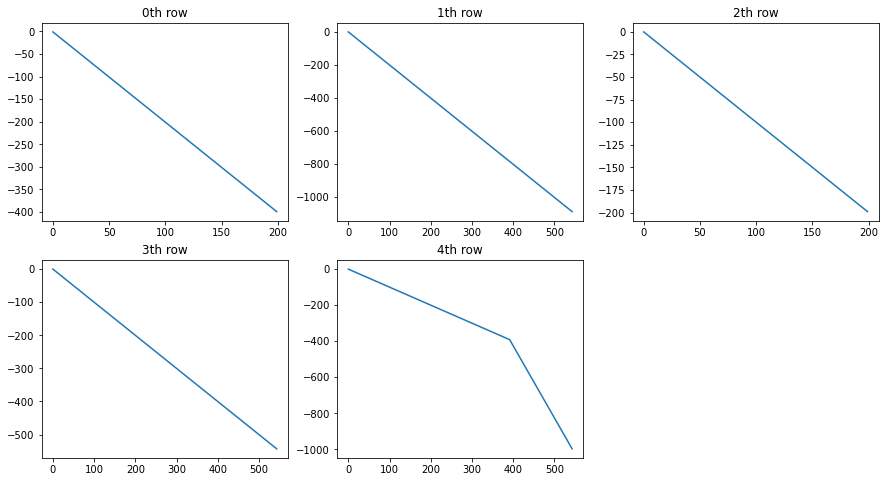

In [23]:
# this is the delta time for each sample to be added to the ending address of range (i_RespEndTime) in order to provide the range in ns for each range waveform sample
print(rec_wf_sample_loc.shape)

plt.figure(figsize=(15,8))
for i in range(rec_wf_sample_loc.shape[0]):
    plt.subplot(2,3,i+1)
    plt.plot(rec_wf_sample_loc[i, :])
    plt.title(f'{i}th row')
    
plt.show()
plt.close()


In [24]:
print(rec_wf_sample_loc[4, 390:394])
compression_switch_ind = 392

[-390.  -391.  -393.5 -397.5]


In [25]:
combined_data = pd.merge(data01, data14, on=['record_index', 'shot_number'])

In [26]:
len(data01.record_index.unique())

1610

In [27]:
len(data14.record_index.unique())

25875

In [28]:
len(combined_data.record_index.unique())

928

# Find a specific shot to work with

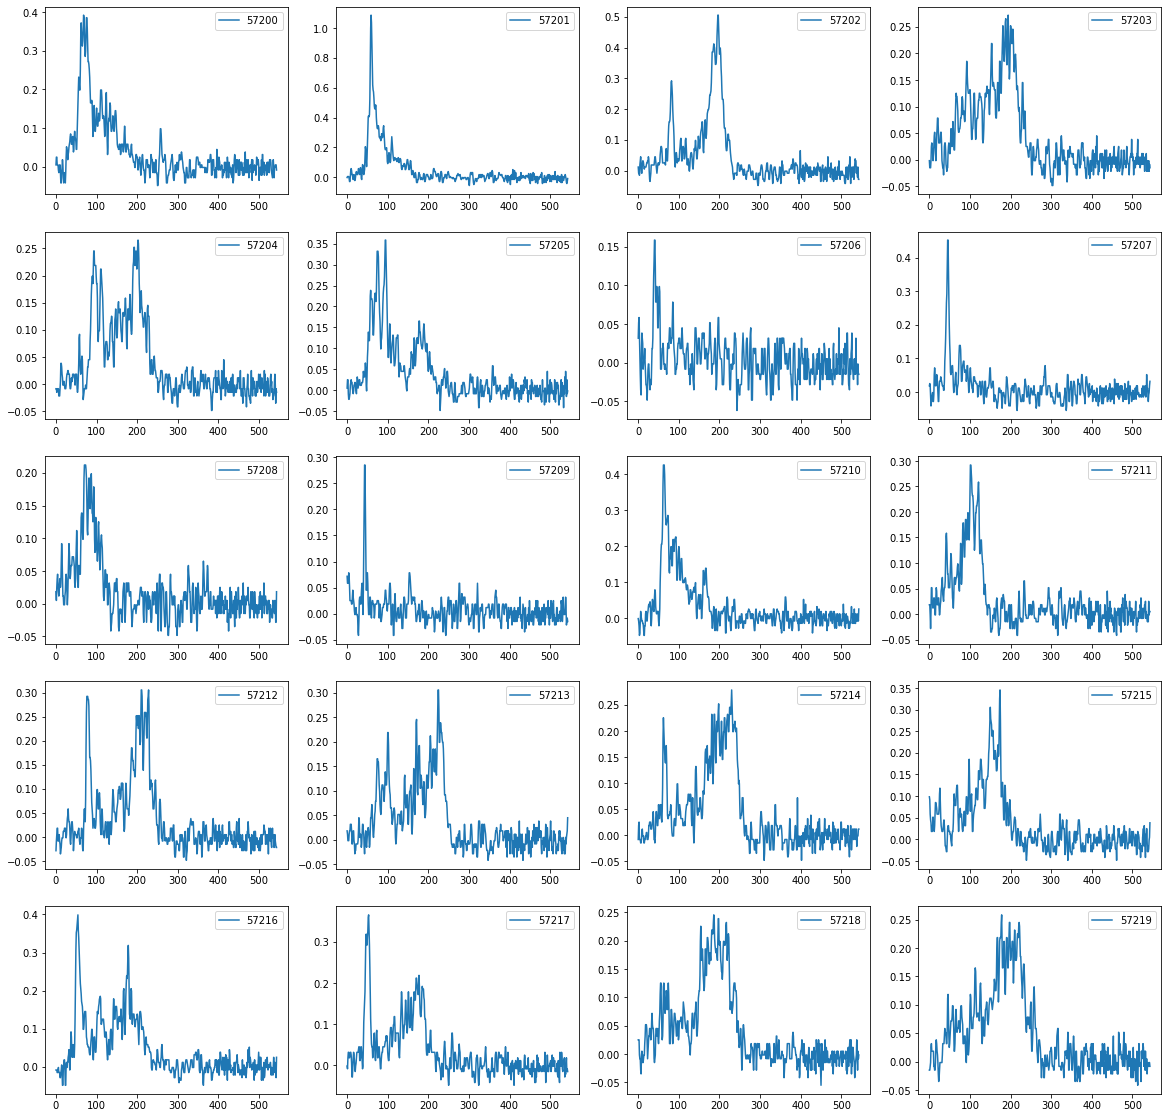

In [29]:
# let's find a waveform within the record of our interest with distinct 2 peaks to work with 

inds = np.where(record_index == record)[0]
plt.figure(figsize=(20,20))
for i, ind in enumerate(inds[0:20]):
    plt.subplot(5,4,i+1)
    plt.plot(rec_wf[ind,:], label=str(ind))
    plt.legend()
plt.show()
plt.close()

In [30]:
ind = 57202

shot = shot_number[ind]
record = record_index[ind]

In [31]:
print(f'we are going to work with record index = {record} and shot number = {shot}')

we are going to work with record index = 226677189 and shot number = 3


# Processing of GLAS data

First, we want to be able to plot the following metrics on the same plot where x = Lidar return and y = distance: 
1. Received waveform (rec_wf) 
2. The filtered/smoothed waveform 
3. Signal beginning 
4. Signal end 
5. Centroid 

In [32]:
# In order to plot sig_begin_offset and sig_end_offset together with the waveform, some translation is needed
# Since we eventually want to calculate things in distance, let's make the plot i

# first, the offsets needed to be added to the centroid elevation to get distance from satelite 
combined_data['sig_begin_distance'] = combined_data.sig_begin_offset + combined_data.ref_range
combined_data['sig_end_distance'] = combined_data.sig_end_offset + combined_data.ref_range
combined_data['centroid_distance'] = combined_data.centroid_offset + combined_data.ref_range

# then, we want to find the coordinates of received waveform digital bins as distance as well 
# we can do this by combining a few parameters 
# for each record index, the corresponding distances are going to be: 
speed_of_light = 299792458   # m/s
seconds_in_nanoseconds = 10 ** -9 

digital_bins_in_distance = ((
    rec_wf_sample_loc[data01.rec_wf_location_ind - 1]  # ns (a len(data01) x 544 array with delta offset for all digital bins, offset for bin 0 = 0)
    + data01['rec_wf_response_end_time'].values.reshape(-1,1) # ns (last time stamp of signal returns, should correspond to digital bin 0)
    - data01['tx_wf_start_time'].values.reshape(-1,1)  # ns (time stamp of the transmit waveform peak)
) * seconds_in_nanoseconds * speed_of_light) / 2


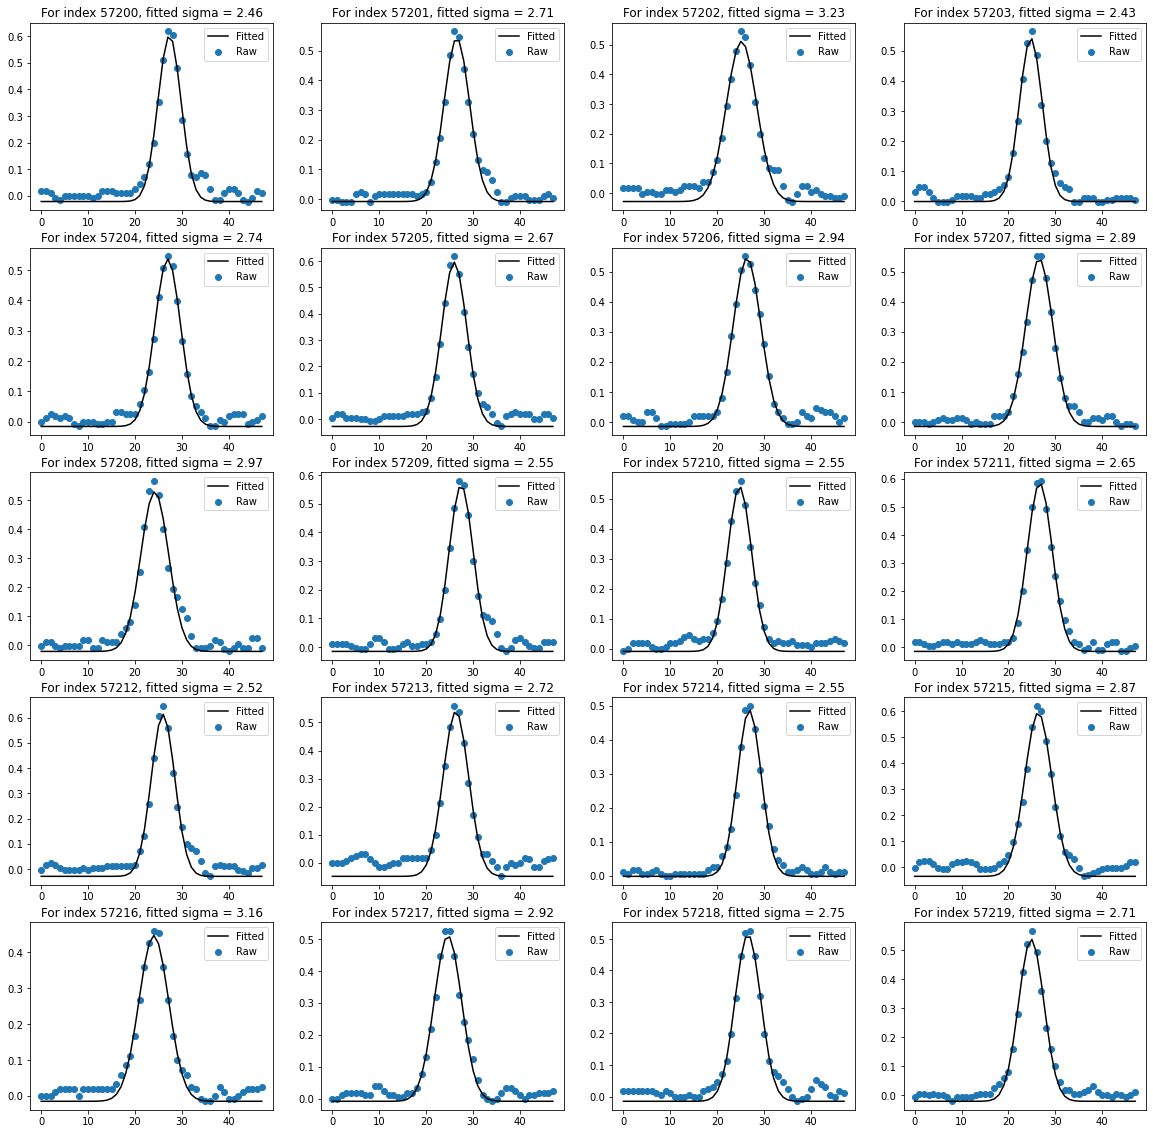

In [33]:
# we also need to figure out how the raw waveform is smoothed, the Sun et al 2008 paper stated that 
# "The waveform was first filtered by a Gaussian filter of a width similar to the transmitted laser pulse."
# let's find out what is the width of the transmitted laser pulse 
# assuming "width" of the Gaussian = sigma of the Gaussian here... 

from scipy import optimize

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-1 * ((x - mean)**2) / (2 * (stddev**2)))

inds = np.where(record_index == record)[0]
plt.figure(figsize=(20,20))
for i, idx in enumerate(inds[0:20]):
    y = tx_wf[idx, :]
    x = np.arange(len(y))
    # optimizer can't deal with negative numbers 
    offset = y.min()
    y -= offset

    popt, _ = optimize.curve_fit(gaussian, x, y, p0 = [0.5, 25, 1])
    plt.subplot(5,4,i+1)
    plt.scatter(x, y+offset, label='Raw')
    plt.plot(x, gaussian(x, *popt)+offset, 'k-', label='Fitted')
    plt.title(f'For index {idx}, fitted sigma = {round(popt[2],2)}')
    plt.legend()
plt.show()
plt.close()

# eye balling sigma to be ~3 

In [34]:
ind = 57202

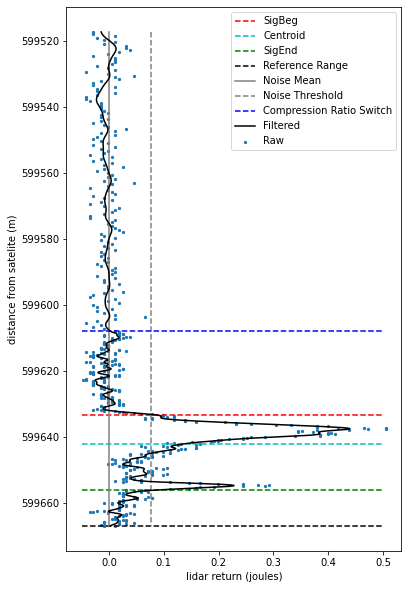

In [35]:
def find_record(df, record_of_interest, shot_of_interest):
    return df.loc[(df.record_index == record_of_interest) & (df.shot_number == shot_of_interest)]

def plot_based_on_ind(ind):
    shot = shot_number[ind]
    record = record_index[ind]
    y = digital_bins_in_distance[ind]
    x = rec_wf[ind]
    rec_to_plot = find_record(combined_data, record, shot)
    filtered = gaussian_filter1d(input=x, sigma=3)

    # move the reference range to the bottom of received wf 
    # TODO: is this legit...?? 
    bias = 0
    bias = y.max() - rec_to_plot.ref_range.iloc[0]

    plt.figure(figsize=(6,10))
    plt.scatter(x, y, s=5, label='Raw')
    
    # plot various variables found in GLAH14
    plt.plot([-0.05, 0.5], np.array([rec_to_plot.sig_begin_distance, rec_to_plot.sig_begin_distance]) + bias, 'r--', label='SigBeg')
    plt.plot([-0.05, 0.5], np.array([rec_to_plot.centroid_distance, rec_to_plot.centroid_distance]) + bias, 'c--', label='Centroid')
    plt.plot([-0.05, 0.5], np.array([rec_to_plot.sig_end_distance, rec_to_plot.sig_end_distance]) + bias, 'g--', label='SigEnd')
    plt.plot([-0.05, 0.5], np.array([rec_to_plot.ref_range, rec_to_plot.ref_range]) + bias, 'k--', label='Reference Range')

    # plot noise mean and std from GLAH01
    plt.plot([rec_to_plot.noise_mean, rec_to_plot.noise_mean], [y.min(), y.max()], '0.5', label='Noise Mean')
    n_sig = 3.5
    noise_threshold = rec_to_plot.noise_mean + n_sig * rec_to_plot.noise_sd
    plt.plot([noise_threshold, noise_threshold], [y.min(), y.max()], color='0.5', linestyle='dashed', label='Noise Threshold')
    
    # plot where compression started being different 
    # TODO: need to make sure compression ratio switch always happens before SigBeg 
    plt.plot([-0.05, 0.5], [y[compression_switch_ind], y[compression_switch_ind]], 'b--', label='Compression Ratio Switch')
    plt.plot(filtered, y, 'k-', label='Filtered')
    
    plt.gca().invert_yaxis()
    plt.xlabel('lidar return (joules)')
    plt.ylabel('distance from satelite (m)')
    plt.legend()
    plt.show()
    plt.close()
    
plot_based_on_ind(ind)

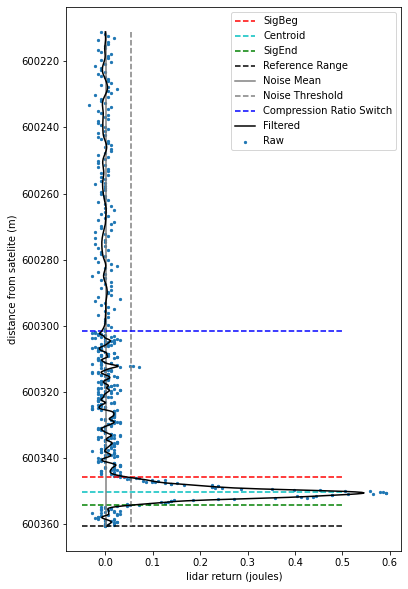

In [36]:
plot_based_on_ind(15727)

# Alright, how about the actual percentile energies 

In [133]:

def interpolate_wf(bins, wf, target, area_to_include):
    """
    if area_to_include = 'above', the function returns the area between the target location to the "upper bound" (larger value) bin
    if area_to_include = 'below', the function returns the area between the target location to the "lower bound" (smaller value) bin
    """        
    upper_ind = np.where(bins > target)[0].max()
    lower_ind = np.where(bins < target)[0].min()
    # since bins goes from large to small values, the "upper bound" index would be smaller than the "lower bound" index
    assert lower_ind - upper_ind == 1
    
    x_upper = bins[upper_ind]
    x_lower = bins[lower_ind]
    y_upper = wf[upper_ind]
    y_lower = wf[lower_ind]
    
    x_mid = (x_upper + x_lower) / 2.
    x_span = x_upper - x_lower 
    
    if area_to_include == 'above':
        if target < x_mid:
            energy = (x_mid - target) / x_span * y_lower  # energy to add to the lower bin
            bin_to_modify = lower_ind
        else:
            energy = (x_mid - target) / x_span * y_upper  # energy to subtract out of the upper bin
            bin_to_modify = upper_ind 
    elif area_to_include == 'below':
        if target < x_mid:
            energy = (target - x_mid) / x_span * y_lower  # energy to subtract out of the lower bin
            bin_to_modify = lower_ind
        else:
            energy = (target - x_mid) / x_span * y_upper  # energy to add to the upper bin
            bin_to_modify = upper_ind
    else:
        raise NotImplementedError('Please specify whether we want to include area above or below the target to the bounds')
            
    
    return bin_to_modify, energy

In [168]:
def find_ground_peak(bins, wf, sig_end, buffer=1):
    valid_area = select_valid_area_no_interpolation(bins, wf, bins.min(), sig_end)
    assert buffer >= 1
    i = buffer 
    while i < len(bins) -1 and (valid_area[i] <= valid_area[i-1] or valid_area[i] <= valid_area[i+1]):
        i += 1
        
    return bins[i]
        

In [169]:

def smooth_wf(input_wf, sigma=3):
    return gaussian_filter1d(input=input_wf, sigma=sigma)

def denoise_wf(input_wf, noise_level):
    return input_wf - noise_level 

def select_valid_area_no_interpolation(bins, wf, beg, end):
    # initialize output 
    output = np.zeros(len(wf))
    
    # within signal beginning and end locations, set otuput to be equal to input wf
    valid = np.where((bins > beg) & (bins < end))[0]
    output[valid] = wf[valid]
    
    # min at 0
    output = np.maximum(output, 0)
    
    return output

def select_valid_area(bins, wf, beg, end):
    # initialize output 
    output = np.zeros(len(wf))
    
    # within signal beginning and end locations, set otuput to be equal to input wf
    valid = np.where((bins > beg) & (bins < end))[0]
    output[valid] = wf[valid]
    
    # for the begining and end bin, interpolate 
    # bins goes from large values (furthest away from satellite) to small (closest to satellite)
    bin_to_modify, energy = interpolate_wf(bins, wf, beg, 'above')
    bins[bin_to_modify] += energy
    bin_to_modify, energy = interpolate_wf(bins, wf, end, 'below')
    bins[bin_to_modify] += energy
    
    # min at 0
    output = np.maximum(output, 0)
    
    return output

def plot_percentile_heights(ind, scipy_interpolate=False):
    shot = shot_number[ind]
    record = record_index[ind]

    bins = digital_bins_in_distance[ind]
    raw_wf = rec_wf[ind]
    other_data = find_record(combined_data, record, shot)

    # move the reference range to the bottom of received wf 
    bias = bins.max() - other_data.ref_range.iloc[0]
    sig_beg = other_data.sig_begin_distance.iloc[0] + bias
    sig_end = other_data.sig_end_distance.iloc[0] + bias
    # if the compression ratio has a kink in it (ie the compression ratio is not the same for begininng/end of the waveform, 
    # then make sure that the compression switch happened before actual signal beginning that's used in processing 
    if other_data.rec_wf_location_ind.iloc[0] == 5:
        assert bins[compression_switch_ind] < sig_beg
    
    # use gaussian filter to smooth and denoise
    denoised_filtered_wf = denoise_wf(
        input_wf=smooth_wf(raw_wf),
        noise_level=other_data.noise_mean.iloc[0]
    )
    
    if scipy_interpolate:
        bins_x = np.arange(len(bins))
        interpolation_func_bins = interpolate.interp1d(bins_x, bins, kind='linear')
        bins_x_interpolated = np.linspace(bins_x[0], bins_x[-1], (len(bins_x)-1) * 100 + 1)
        bins_interpolated = interpolation_func_bins(bins_x_interpolated)

        interpolated_func_wf = interpolate.interp1d(bins, denoised_filtered_wf, kind='nearest')
        wf_interpolated = interpolated_func_wf(bins_interpolated)

        # select the waveform area between signal beg and end
        valid_wf = select_valid_area_no_interpolation(bins_interpolated, wf_interpolated, sig_beg, sig_end)
        total_energy = valid_wf.sum()
        energy_cumsum = valid_wf.cumsum()        
        ind25 = get_percentile_ind(0.25, total_energy, energy_cumsum)
        ind50 = get_percentile_ind(0.50, total_energy, energy_cumsum)
        ind75 = get_percentile_ind(0.75, total_energy, energy_cumsum)
        h25 = sig_end - bins_interpolated[ind25]
        h50 = sig_end - bins_interpolated[ind50]
        h75 = sig_end - bins_interpolated[ind75]
    
    else:
        denoised_filtered_wf = select_valid_area(bins, denoised_filtered_wf, sig_beg, sig_end)
        total_energy = denoised_filtered_wf.sum()
        energy_cumsum = denoised_filtered_wf.cumsum()
        # TODO: interpolate!! 
        ind25 = get_percentile_ind(0.25, total_energy, energy_cumsum)
        ind50 = get_percentile_ind(0.50, total_energy, energy_cumsum)
        ind75 = get_percentile_ind(0.75, total_energy, energy_cumsum)
        h25 = sig_end - bins[ind25]
        h50 = sig_end - bins[ind50]
        h75 = sig_end - bins[ind75]
        
    ground_h = find_ground_peak(bins, denoised_filtered_wf, sig_end)

    plt.figure(figsize=(6,10))
    plt.scatter(raw_wf, bins, s=5, label='Raw')
    
    # plot various variables found in GLAH14
    plt.plot([-0.05, 0.5], np.array([sig_beg, sig_beg]), 'r--', label='Signal Beginning')
    plt.plot([-0.05, 0.5], np.array([sig_end, sig_end]), 'g--', label='Signal End')

    # plot noise mean and std from GLAH01
    plt.plot([other_data.noise_mean, other_data.noise_mean], [bins.min(), bins.max()], '0.5', label='Noise Mean')
    n_sig = 3.5
    noise_threshold = other_data.noise_mean + n_sig * other_data.noise_sd
    plt.plot([noise_threshold, noise_threshold], [bins.min(), bins.max()], color='0.5', linestyle='dashed', label='Noise Threshold')
    
    # plot filtered wf 
    plt.plot(smooth_wf(raw_wf), bins, 'k-', label='Filtered Waveform')
    
    # plot percentile heights 
    if scipy_interpolate:
        plt.plot([-0.05, 0.5], [bins_interpolated[ind25], bins_interpolated[ind25]], 'b--', label='H25')
        plt.plot([-0.05, 0.5], [bins_interpolated[ind50], bins_interpolated[ind50]], 'c--', label='H50')
        plt.plot([-0.05, 0.5], [bins_interpolated[ind75], bins_interpolated[ind75]], 'm--', label='H75')
    else:
        plt.plot([-0.05, 0.5], [bins[ind25], bins[ind25]], 'b--', label='H25')
        plt.plot([-0.05, 0.5], [bins[ind50], bins[ind50]], 'c--', label='H50')
        plt.plot([-0.05, 0.5], [bins[ind75], bins[ind75]], 'm--', label='H75')
        
    plt.plot([-0.05, 0.5], [ground_h, ground_h], 'y--', label='Ground Peak')
    
    plt.gca().invert_yaxis()
    plt.xlabel('lidar return (joules)')
    plt.ylabel('distance from satelite (m)')
    plt.legend()
    plt.show()
    plt.close()

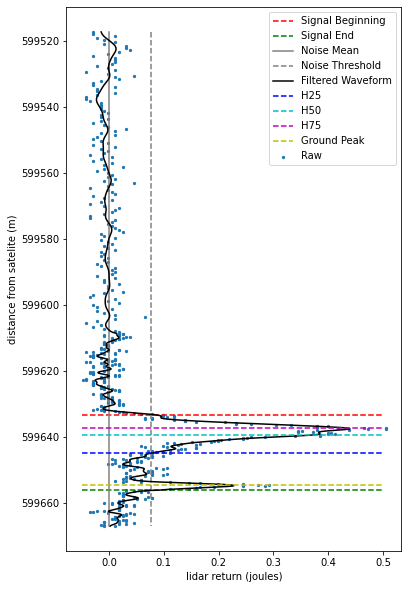

In [170]:
plot_percentile_heights(ind)

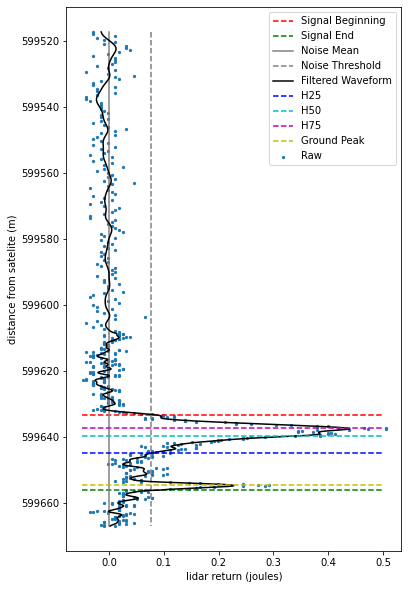

In [171]:
plot_percentile_heights(ind, scipy_interpolate=True)

TODO:
1) store data in better ways   
3) find out which exact allometric equations we're going to use and which references we will be using 
  - find ecoregions or NLCD maps to classify -- how to overlap raster and point data (xarray ds.sel(method = nearest))
  - 
4) LandSat tutorial/example from Joe 